This notebook tests logic expressions used to generate vga timings. This uses standard VGA (http://tinyvga.com/vga-timing/640x480@60Hz). 

My graphics card uses a single 4-bit counter to draw characters and divide the clock by 8.
The divide-by-8 clock is then used to drive two 4-bit counters to count the horizontal position. Because VGA is 800 pixels horizontally, this horizontal counter goes to 100 before being reset (it is driven by the divide-by-8 counter).

The horizontal counter's reset signal also clocks the vertical counter, which is 3 4-bit counters. This counter runs up to 525 before resetting.

The horizontal sync uses an S-R latch with with active-low inputs. The expressions are:
r_expr = ~(n[1] & n[4] & n[6] & ~n[3])
s_expr = ~(n[1] & n[2] & n[3] & n[4])
(n[0] is the LSB of the horizontal counter, n[1] is the second-least significant bit, etc.)
This expressions could be implemented using a 2x4 input NAND IC and an inverter IC.

The horizontal counter is reset at line 100 (line 800 in VGA, but divided by 8). The expression is as follows:
line_expr = ~(n[2] & n[5] & n[6])

The vertical sync doesn't use an S-R latch; instead it simply uses a logic expression:
vsync_expr = ~(n[1] & ~n[2] & n[3] & ~n[4] & n[5] & n[6] & n[7] & n[8])
line_expr = ~(n[2] & n[3] & n[9])

Oh, one more thing: The vertical reset signal should reset at 525 if asynchronous-reset counters are used for the vertical counter, or 524 if synchronous reset counters are used. The expression above works for line 524. Asynchronous counters could be used instead of synchronous counters by loading the asynchronous counters with 0 instead of using the clear signal.

In [1]:
import matplotlib.pyplot as plt

def bits(num, size):
    bits = []
    for i in range(0, size):
        bits.append(num & 1)
        num >>= 1
    return bits

In [2]:
s = []
r = []
line = []
q = []
length = 101

for i in range(0, length):
    n = bits(i, 8) #split the number into an array of bits
    
    r_expr = 1 - (n[1] & n[4] & n[6] & ~n[3]) #reset expression
    s_expr = 1 - (n[1] & n[2] & n[3] & n[4]) #set expression
    line_expr = 1 - (n[2] & n[5] & n[6]) #next line expression
    
    s.append(s_expr)
    r.append(r_expr)
    line.append(line_expr)

In [3]:
for i in range(0, length):
    not_s = ~s[i] & 1
    not_r = ~r[i] & 1
    if (not_s and not_r):
        print('invalid state!')
    
    if (i == 0):
        q.append(1)
    elif (not_s):
        q.append(1)
    elif (not_r):
        q.append(0)
    else:
        q.append(q[i - 1])
for i in range(0, length):
    s[i] += 1.5
    q[i] += 3
    line[i] += 4.5

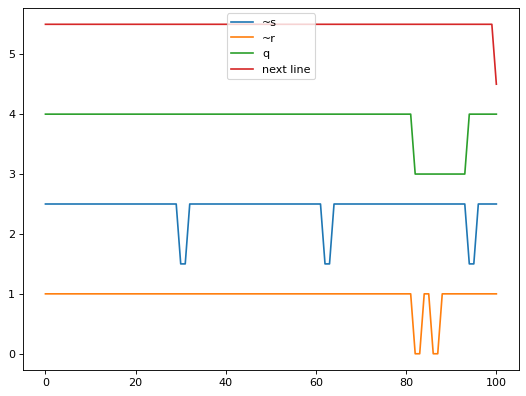

In [4]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(s, label='~s')
plt.plot(r, label='~r')
plt.plot(q, label='q')
plt.plot(line, label='next line')
plt.legend(loc='upper center')

In [5]:
vsync = []
line = []
length = 526

for i in range(0, length):
    n = bits(i, 12) #split the number into an array of bits
    
    vsync_expr = 1 - (n[1] & ~n[2] & n[3] & ~n[4] & n[5] & n[6] & n[7] & n[8]) #vsync expression
    line_expr = 1 - (n[2] & n[3] & n[9]) #next line expression
    
    vsync.append(vsync_expr)
    line.append(line_expr)

In [6]:
for i in range(0, length):
    #s[i] += 1.5
    #q[i] += 3
    line[i] += 1.5

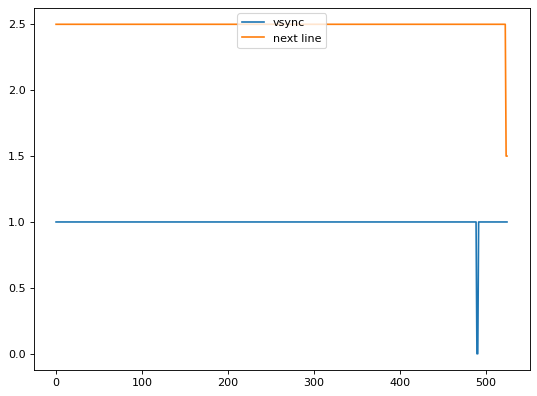

In [7]:
zoom = 0
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(vsync[zoom:], label='vsync')
plt.plot(line[zoom:], label='next line')
plt.legend(loc='upper center')